# Assignment for Week 4 - Decision Trees and Random Forest

**Exercise:** German credit dataset: located in the assign_wk4 folder

**Objective:** to minimize loss from the bank’s perspective.

Bank (by loan manager) needs to decide who will get loan approval based on the applicants’ demographic and socio-economic profiles. The data set consists of 20 variables and classification on applicant whether he/she has good or bad credit risk. The predictive model will provide guidance in making loan approval decision on prospective applicants based on clients’ profiles.

**NOTE:** Based on the accompanying document, a *false positive* will cause the
          bank money to lose money.  **Therefore, throughout this assignment,
          we use *precision* as the preferred accuracy measurement.**
          According to `german_credit_risk_names.doc` (n.d.)

          it is worse to classify a customer as `good` when they are `bad` than
          it is to classify a customer as `bad` when they are `good`

---

# 1 Setup

## 1.A Sanity Check of Provided Data File

Prior to importing any data, we perform a few checks against the file:
* What is the approximate size of the file (will our current configuration
  support the given quantity of data)?
* What is the content of the file and does it use the correct line endings?
* How many rows (lines) are in the file (can be used to double-check that
  the full dataset is loaded by Pandas)?
* Does the data have a header row?


In [1]:
%%bash
declare -a DATA_FILES=("data/german_credit_risk.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

data/german_credit_risk.csv:
    Data file size:      80K
    Data file type:      CSV text
    Number of lines:     1001
    Data header row?     ﻿Checking.Account,Duration,Credit.Hist,Purpose,Credit.Amount,Saving.Account,Employmnet,Disposable.Income,Personal.Status,Other.Debtors,Present.Residence,Property,Age,Other.Loans,Housing,Existing.Credits,Job,Number.Liable,Telephone,Foreign.Worker,Cost.Matrix


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import collections
import IPython.display
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import sklearn.compose
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.tree

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.set_option('max_row', 100)

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED = 42


## 1.C Import the Data


In [3]:
credit_df = pd.read_csv('data/german_credit_risk.csv')
LOGGER.info(f'credit_df.shape ==> {credit_df.shape[0]} rows x {credit_df.shape[1]} cols')
credit_df.head()

2022-02-06 22:45:23 - INFO   -   MSDS-680 - credit_df.shape ==> 1000 rows x 21 cols


Checking.Account  Duration Credit.Hist Purpose  Credit.Amount  \
0              A11         6         A34     A43           1169   
1              A12        48         A32     A43           5951   
2              A14        12         A34     A46           2096   
3              A11        42         A32     A42           7882   
4              A11        24         A33     A40           4870   

  Saving.Account Employmnet  Disposable.Income Personal.Status Other.Debtors  \
0            A65        A75                  4             A93          A101   
1            A61        A73                  2             A92          A101   
2            A61        A74                  2             A93          A101   
3            A61        A74                  2             A93          A103   
4            A61        A73                  3             A93          A101   

   ...  Property Age  Other.Loans Housing Existing.Credits   Job  \
0  ...      A121  67         A143    A152                2  A173   
1  ...      A121  22         A143    A152                1  A173   
2  ...      A121  49         A143    A152                1  A172   
3  ...      A122  45         A143    A153                1  A173   
4  ...      A124  53         A143    A153                2  A173   

  Number.Liable  Telephone Foreign.Worker Cost.Matrix  
0             1       A192           A201           1  
1             1       A191           A201           2  
2             2       A191           A201           1  
3             2       A191           A201           1  
4             2       A191           A201           2  

[5 rows x 21 columns]

In [4]:
credit_df.describe()

Duration  Credit.Amount  Disposable.Income  Present.Residence  \
count  1000.000000    1000.000000        1000.000000        1000.000000   
mean     20.903000    3271.258000           2.973000           2.845000   
std      12.058814    2822.736876           1.118715           1.103718   
min       4.000000     250.000000           1.000000           1.000000   
25%      12.000000    1365.500000           2.000000           2.000000   
50%      18.000000    2319.500000           3.000000           3.000000   
75%      24.000000    3972.250000           4.000000           4.000000   
max      72.000000   18424.000000           4.000000           4.000000   

               Age  Existing.Credits  Number.Liable  Cost.Matrix  
count  1000.000000       1000.000000    1000.000000  1000.000000  
mean     35.546000          1.407000       1.155000     1.300000  
std      11.375469          0.577654       0.362086     0.458487  
min      19.000000          1.000000       1.000000     1.000000  
25%      27.000000          1.000000       1.000000     1.000000  
50%      33.000000          1.000000       1.000000     1.000000  
75%      42.000000          2.000000       1.000000     2.000000  
max      75.000000          4.000000       2.000000     2.000000

In [5]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Checking.Account   1000 non-null   object
 1   Duration           1000 non-null   int64 
 2   Credit.Hist        1000 non-null   object
 3   Purpose            1000 non-null   object
 4   Credit.Amount      1000 non-null   int64 
 5   Saving.Account     1000 non-null   object
 6   Employmnet         1000 non-null   object
 7   Disposable.Income  1000 non-null   int64 
 8   Personal.Status    1000 non-null   object
 9   Other.Debtors      1000 non-null   object
 10  Present.Residence  1000 non-null   int64 
 11  Property           1000 non-null   object
 12  Age                1000 non-null   int64 
 13  Other.Loans        1000 non-null   object
 14  Housing            1000 non-null   object
 15  Existing.Credits   1000 non-null   int64 
 16  Job                1000 non-null   object
 

# 2 Exploratory Data Analysis

## 2.A Convert Ordinals

In some cases, the data set contains contains categorical values
(e.g. Checking Account: A11, A12, A13, A14) which could reasonably be converted
to ordinal values (a value of 200DM is greater than 0DM)

In [6]:
checking_account = {
    'A11':  1,
    'A12':  200,
    'A13':  500,
    'A14':  0
}

def convert_checking_account(value):
    return checking_account[value]

savings_account = {
    'A61':  100,
    'A62':  500,
    'A63': 1000,
    'A64': 5000,
    'A65':    0
}

def convert_savings_account(value):
    return savings_account[value]

employment = {
    'A71':  0,
    'A72':  1,
    'A73':  4,
    'A74':  7,
    'A75': 10
}

def convert_employment(value):
    return employment[value]

credit_df['Checking.Account']   = credit_df['Checking.Account'].apply(lambda x: convert_checking_account(x))
credit_df['Saving.Account']     = credit_df['Saving.Account'].apply(lambda x: convert_savings_account(x))
credit_df['Employmnet']         = credit_df['Employmnet'].apply(lambda x: convert_employment(x))
credit_df.head()

Checking.Account  Duration Credit.Hist Purpose  Credit.Amount  \
0                 1         6         A34     A43           1169   
1               200        48         A32     A43           5951   
2                 0        12         A34     A46           2096   
3                 1        42         A32     A42           7882   
4                 1        24         A33     A40           4870   

   Saving.Account  Employmnet  Disposable.Income Personal.Status  \
0               0          10                  4             A93   
1             100           4                  2             A92   
2             100           7                  2             A93   
3             100           7                  2             A93   
4             100           4                  3             A93   

  Other.Debtors  ...  Property Age  Other.Loans Housing Existing.Credits  \
0          A101  ...      A121  67         A143    A152                2   
1          A101  ...      A121  22         A143    A152                1   
2          A101  ...      A121  49         A143    A152                1   
3          A103  ...      A122  45         A143    A153                1   
4          A101  ...      A124  53         A143    A153                2   

    Job Number.Liable  Telephone Foreign.Worker Cost.Matrix  
0  A173             1       A192           A201           1  
1  A173             1       A191           A201           2  
2  A172             2       A191           A201           1  
3  A173             2       A191           A201           1  
4  A173             2       A191           A201           2  

[5 rows x 21 columns]


## 2.B Label Encoding

Initially, the labels (y values) are 1 and 2.  Below, we encode them as 0 and 1
(boolean).

In [7]:
# It's only necessary to perform LabelEncoding one time... if this code
# block is re-run on an already encoded DataFrame, skip the transformation
if credit_df['Cost.Matrix'].max() == 2:
    # LabelEncoder transforms the label values (y) between 0 and n_classes - 1
    costLabelEncoder = sklearn.preprocessing.LabelEncoder()

    # Since we have two classes (1, 2) we will end up with (0, 1)
    LOGGER.info(f"Original classes (y values): {credit_df['Cost.Matrix'].min()}, {credit_df['Cost.Matrix'].max()}")

    credit_df['Cost.Matrix'] = costLabelEncoder.fit_transform(credit_df['Cost.Matrix'])

    for value in credit_df['Cost.Matrix'].unique():
        LOGGER.info(f"Previous y value of {costLabelEncoder.inverse_transform([value])[0]} is now {value}")

credit_df.head()


2022-02-06 22:45:23 - INFO   -   MSDS-680 - Original classes (y values): 1, 2
2022-02-06 22:45:23 - INFO   -   MSDS-680 - Previous y value of 1 is now 0
2022-02-06 22:45:23 - INFO   -   MSDS-680 - Previous y value of 2 is now 1


Checking.Account  Duration Credit.Hist Purpose  Credit.Amount  \
0                 1         6         A34     A43           1169   
1               200        48         A32     A43           5951   
2                 0        12         A34     A46           2096   
3                 1        42         A32     A42           7882   
4                 1        24         A33     A40           4870   

   Saving.Account  Employmnet  Disposable.Income Personal.Status  \
0               0          10                  4             A93   
1             100           4                  2             A92   
2             100           7                  2             A93   
3             100           7                  2             A93   
4             100           4                  3             A93   

  Other.Debtors  ...  Property Age  Other.Loans Housing Existing.Credits  \
0          A101  ...      A121  67         A143    A152                2   
1          A101  ...      A121  22         A143    A152                1   
2          A101  ...      A121  49         A143    A152                1   
3          A103  ...      A122  45         A143    A153                1   
4          A101  ...      A124  53         A143    A153                2   

    Job Number.Liable  Telephone Foreign.Worker Cost.Matrix  
0  A173             1       A192           A201           0  
1  A173             1       A191           A201           1  
2  A172             2       A191           A201           0  
3  A173             2       A191           A201           0  
4  A173             2       A191           A201           1  

[5 rows x 21 columns]

# 3 Decision Tree Classifier

## 3.A Train / Test Split


In [8]:
# Identify the label column:
label_column = 'Cost.Matrix'

# All other columns are inputs (features)
feature_columns = [c for c in credit_df.columns if c != label_column]

# X = input, y = labels
X = credit_df[feature_columns].values
y = credit_df[label_column].values

# This will randomly split the data according to the provided ratio (0.2)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


LOGGER.info(f'X_train.shape ==> {X_train.shape[0]} rows x {X_train.shape[1]} cols')
LOGGER.info(f'X_test.shape  ==> {X_test.shape[0]}  rows x {X_test.shape[1]} cols')

LOGGER.info(f'y_train.shape ==> {y_train.shape[0]} rows')
LOGGER.info(f'y_test.shape  ==> {y_test.shape[0]}  rows')

CATEGORICAL_COLUMNS = ['Credit.Hist', 'Purpose', 'Personal.Status', 'Other.Debtors', 'Property', 'Other.Loans', 'Housing', 'Job', 'Telephone', 'Foreign.Worker']

transformer = sklearn.compose.ColumnTransformer(transformers=[
        # NOTE: Scaling doesn't affect the Decision Tree, therefore we only
        #       transform categorical columns using OneHotEncoder, we don't
        #       bother applying MinMaxScaler to numberical columns
        (f'Encoder', sklearn.preprocessing.OneHotEncoder(), [credit_df.columns.tolist().index(c) for c in CATEGORICAL_COLUMNS])
    ], remainder='passthrough')

# Transformed X_train data
Xt_train = transformer.fit_transform(X_train)
Xt_test  = transformer.transform(X_test)


2022-02-06 22:45:24 - INFO   -   MSDS-680 - X_train.shape ==> 800 rows x 20 cols
2022-02-06 22:45:24 - INFO   -   MSDS-680 - X_test.shape  ==> 200  rows x 20 cols
2022-02-06 22:45:24 - INFO   -   MSDS-680 - y_train.shape ==> 800 rows
2022-02-06 22:45:24 - INFO   -   MSDS-680 - y_test.shape  ==> 200  rows


## 3.B Decision Tree Classifier

**Findings:**  With default `DecisionTreeClassifier` hyperparameters (`gini`
               criteria, no max depth, etc) the decision tree only achieved
               52% precision.  Interesting note, prior to converting some of the
               categorical values to ordinals, the precision achieved was 48%.


2022-02-06 22:45:24 - INFO   -   MSDS-680 - Precision: 51.79%.  Recall: 49.15%.  F1 Score: 50.43%
2022-02-06 22:45:24 - INFO   -   MSDS-680 - Tree has 321 nodes, 161 leaves, and a max depth of 20


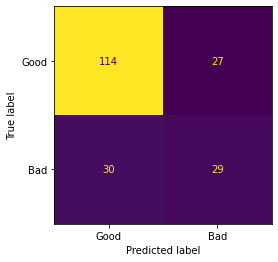

In [9]:
model = sklearn.tree.DecisionTreeClassifier(random_state=RANDOM_SEED)

model.fit(Xt_train, y_train)

# Predict labels for previously unseen data
y_pred = model.predict(Xt_test)

# Print performance metrics
precision   = sklearn.metrics.precision_score(y_test, y_pred)
recall      = sklearn.metrics.recall_score(y_test, y_pred)
f1          = sklearn.metrics.f1_score(y_test, y_pred)

LOGGER.info(f'Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

LOGGER.info(f'Tree has {model.tree_.node_count} nodes, {model.get_n_leaves()} leaves, and a max depth of {model.get_depth()}')

# Display the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred=y_pred, colorbar=False, display_labels=['Good', 'Bad'])


## 3.C Tree Visualization

**Interpretation:**  According to the tree visualization, the root node
                     is the ordinal value for Checking.Account (e.g. column x0),
                     utilizing the condition `x <= 0.5` which indicates that the
                     individual does not have a checking account.


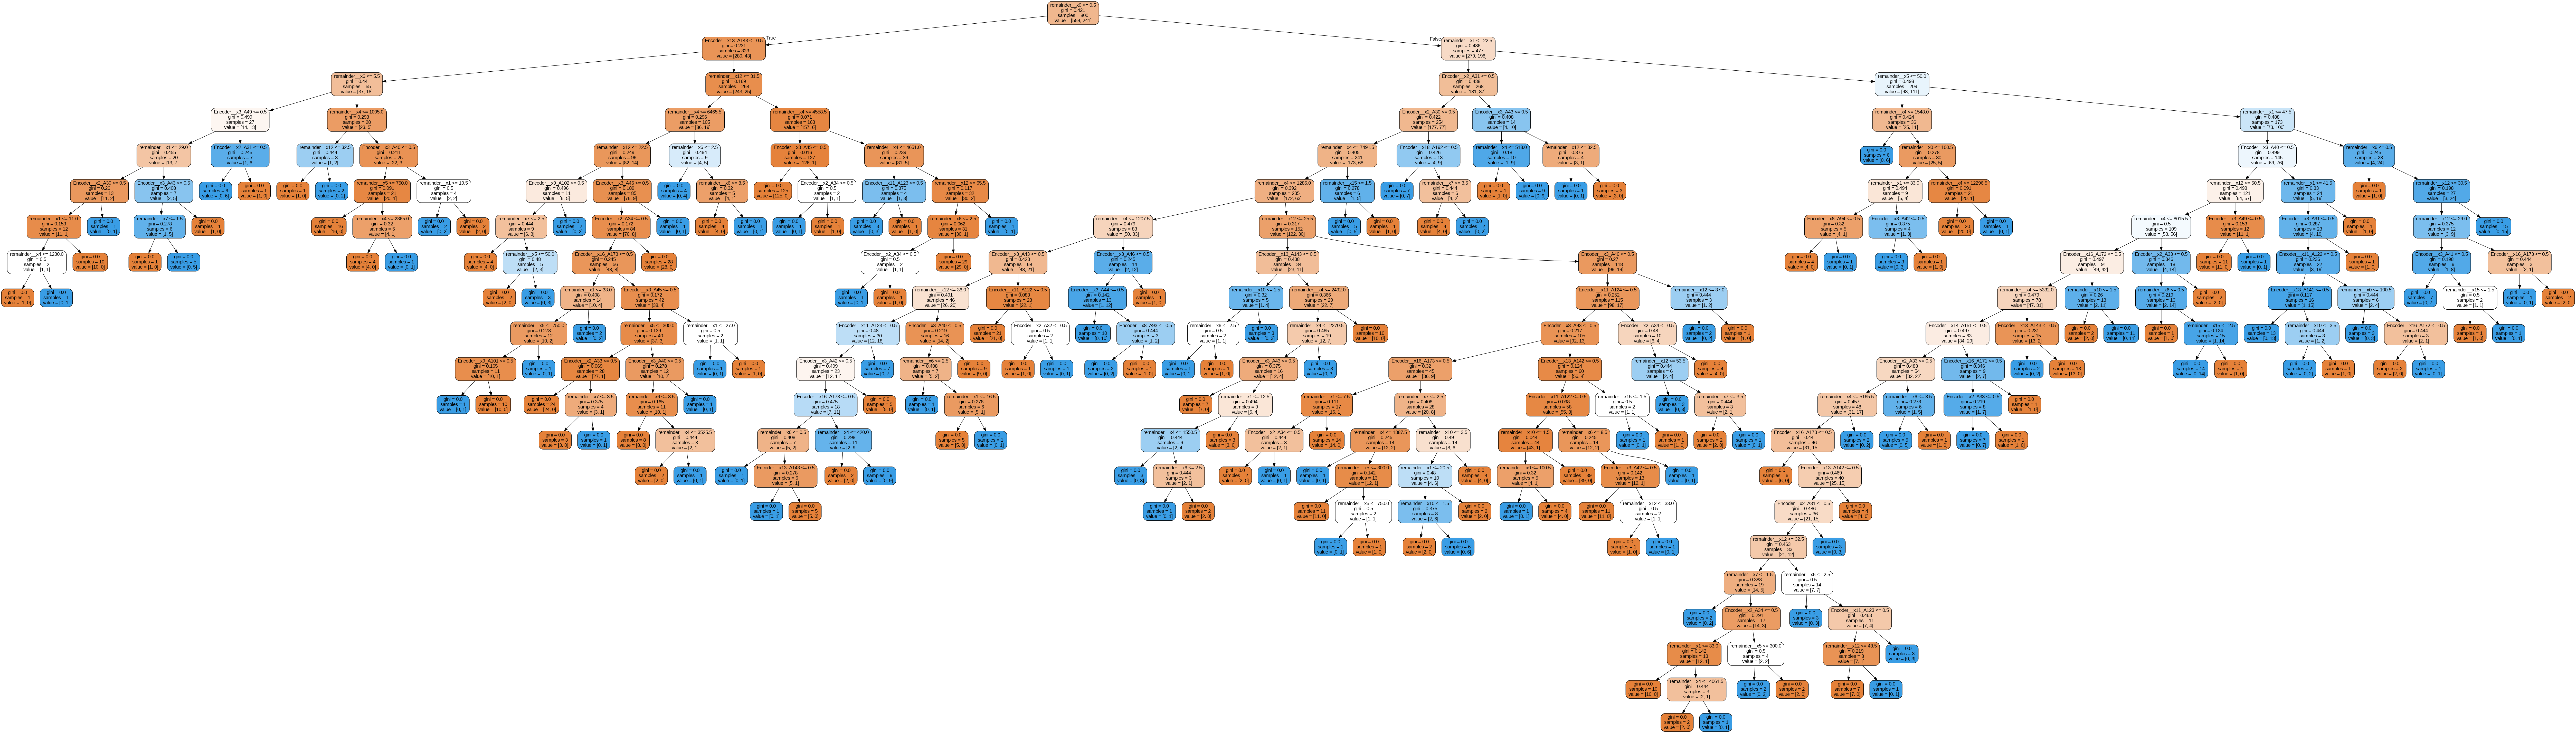

In [10]:
def write_tree(model, transformer, filename, display=True):
    dot_data = sklearn.tree.export_graphviz(model,
                                            feature_names=transformer.get_feature_names_out(),
                                            out_file=None,
                                            filled=True,
                                            rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]

    graph.write_png(filename)

    if display:
        return IPython.display.Image(filename=filename) 

write_tree(model, transformer, 'initial-decision-tree.png')


## 3.D Pruning Using Cost Complexity 

Using Cost Complexity to prune the tree, we were able to improve from `52%` to
`65%`

The resulting tree has 5 nodes, 3 leaves, and a max depth of 2.  Other than
the root node (which utilizes Checking.Account), the other primary discriminator
is duration of holding an account.


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

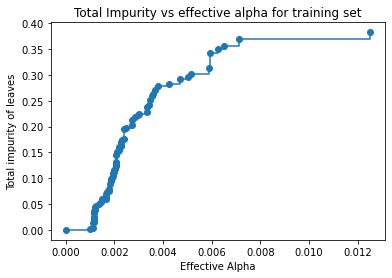

In [11]:
path = model.cost_complexity_pruning_path(Xt_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective Alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0010 ... Precision: 51.79%.  Recall: 49.15%.  F1 Score: 50.43%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0011 ... Precision: 51.79%.  Recall: 49.15%.  F1 Score: 50.43%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0012 ... Precision: 56.00%.  Recall: 47.46%.  F1 Score: 51.38%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0014 ... Precision: 56.00%.  Recall: 47.46%.  F1 Score: 51.38%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0015 ... Precision: 55.10%.  Recall: 45.76%.  F1 Score: 50.00%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0017 ... Precision: 54.00%.  Recall: 45.76%.  F1 Score: 49.54%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0018 ... Precision: 53.85%.  Recall: 47.46%.  F1 Score: 50.45%
2022-02-06 22:45:34 - DEBUG  -   MSDS-680 - Cost Complexity Alpha: 0.0019 ..

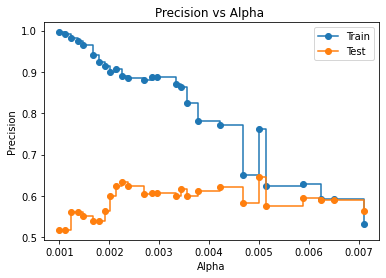

In [12]:

def ccp_alpha_generator(sequence):
    previous_ccp_alpha  = 0
    epsilon             = 0.0001
    index               = 0

    while index < len(sequence):
        if sequence[index] > (previous_ccp_alpha + epsilon):
            previous_ccp_alpha = sequence[index]
            yield sequence[index]
        index = index + 1

metrics_df      = pd.DataFrame(columns=['alpha', 'train_precision', 'test_precision', 'test_recall', 'test_f1'])
best_model_iter = None

for ccp_alpha in ccp_alpha_generator(ccp_alphas):
    model_iter = sklearn.tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=RANDOM_SEED)
    model_iter.fit(Xt_train, y_train)

    # Predict labels for training data, for comparison
    ytrain_pred  = model_iter.predict(Xt_train)

    # Predict labels for previously unseen data
    ytest_pred = model_iter.predict(Xt_test)

    # Print performance metrics
    train_precision = sklearn.metrics.precision_score(y_train, ytrain_pred, zero_division=0)
    precision       = sklearn.metrics.precision_score(y_test, ytest_pred, zero_division=0)
    recall          = sklearn.metrics.recall_score(y_test, ytest_pred, zero_division=0)
    f1              = sklearn.metrics.f1_score(y_test, ytest_pred, zero_division=0)

    if precision > 0:
        LOGGER.debug(f'Cost Complexity Alpha: {ccp_alpha:.4f} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

        if best_model_iter is None or precision > metrics_df[metrics_df.test_precision == metrics_df.test_precision.max()].head(1)['test_precision'].values[0]:
            best_model_iter = model_iter

        metrics_df = metrics_df.append({
            'alpha':            ccp_alpha,
            'train_precision':  train_precision,
            'test_precision':   precision,
            'test_recall':      recall,
            'test_f1':          f1,
            }, ignore_index=True)


alpha, train_precision, test_precision, test_recall, test_f1 = metrics_df[metrics_df.test_precision == metrics_df.test_precision.max()].head(1).values[0]

LOGGER.info(f'Best PRECISION when: alpha={alpha:0.4f} ... Precision: {test_precision:.2%}.  Recall: {test_recall:.2%}.  F1: {test_f1:.2%}')
LOGGER.info(f'Tree has {best_model_iter.tree_.node_count} nodes, {best_model_iter.get_n_leaves()} leaves, and a max depth of {best_model_iter.get_depth()}')

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Alpha ")
ax.plot(metrics_df.alpha, metrics_df.train_precision, label='Train', marker='o', drawstyle='steps-post')
ax.plot(metrics_df.alpha, metrics_df.test_precision, label='Test', marker='o', drawstyle='steps-post')
ax.legend()


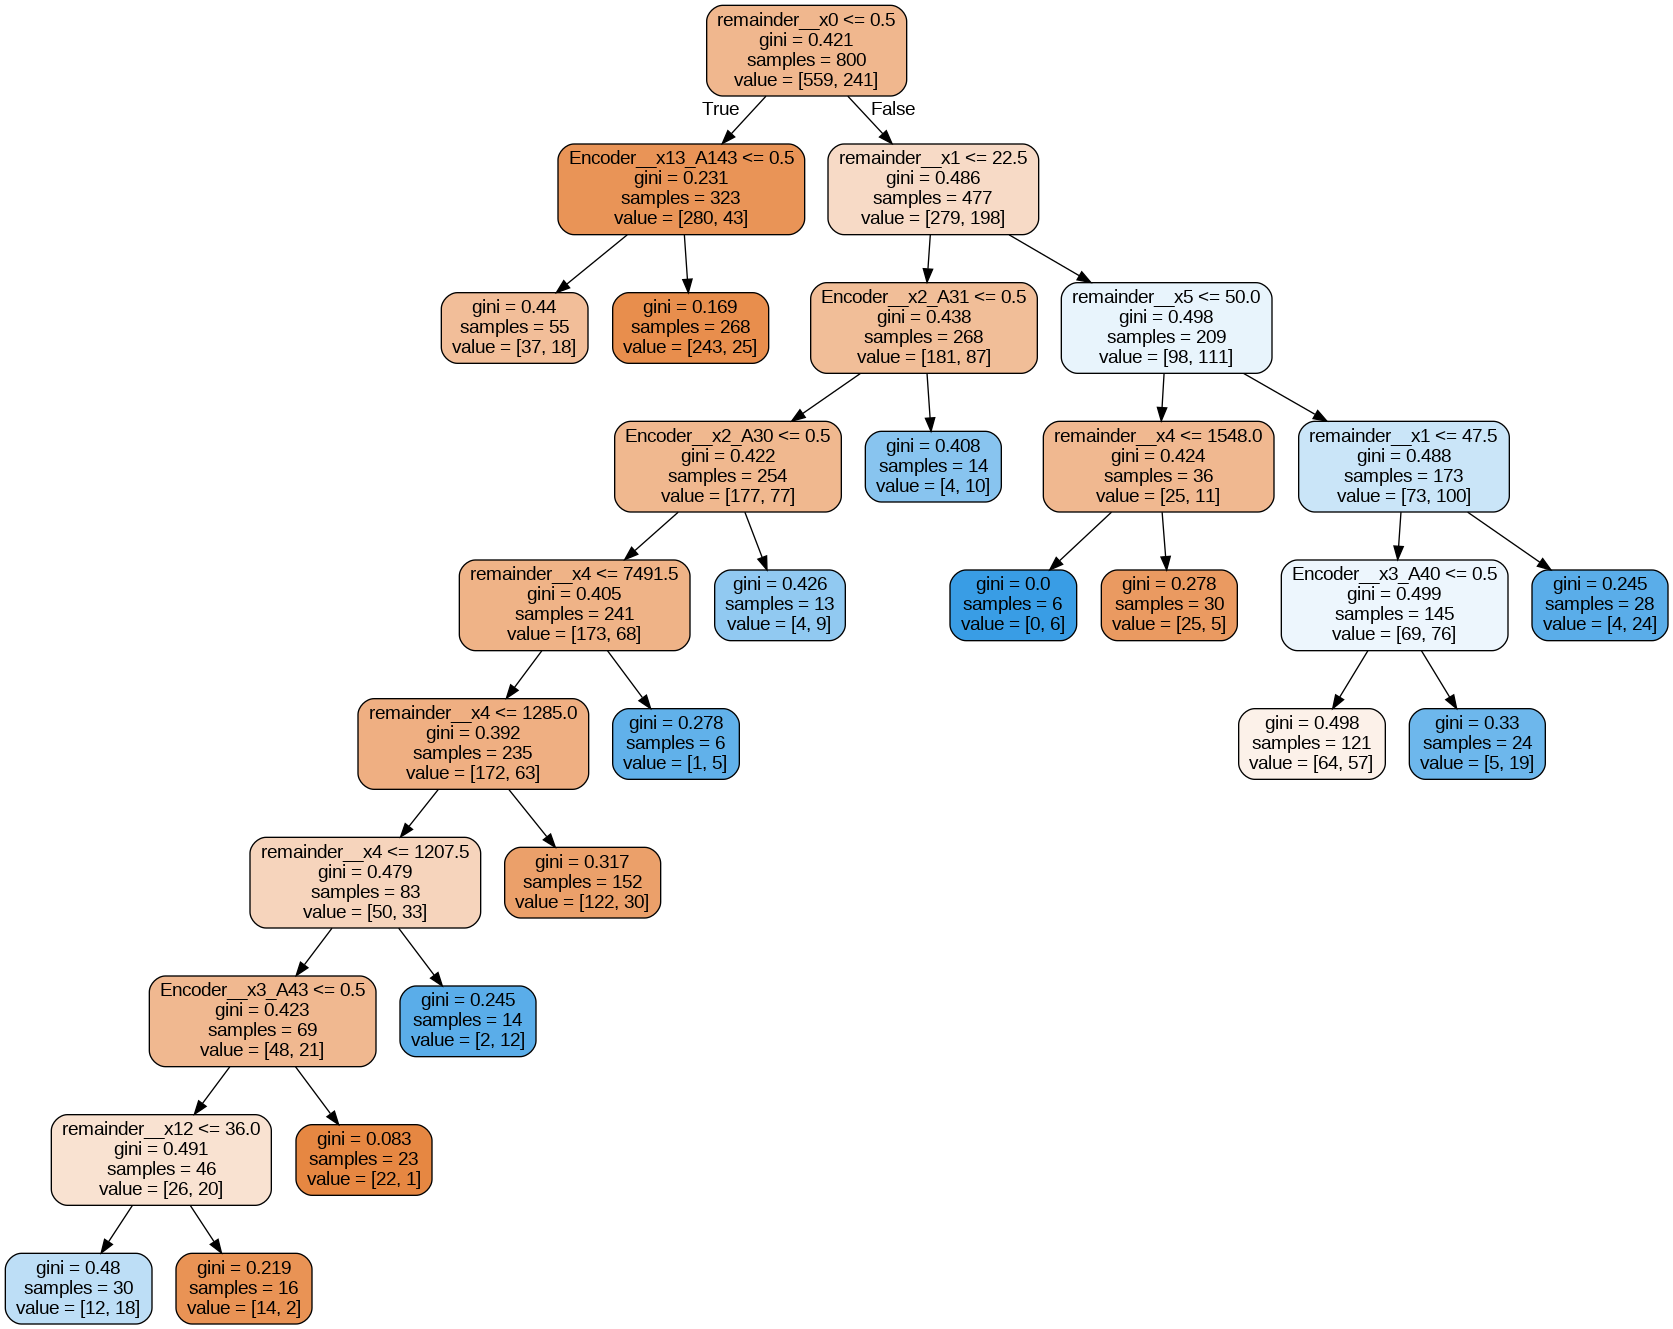

In [13]:
write_tree(best_model_iter, transformer, 'best-alpha-tree.png')


## 3.E Pruning Using `max_depth`

Using maximum depth to prune the tree, we were able to improve from `52%` to
`70%`


2022-02-06 22:45:35 - DEBUG  -   MSDS-680 - Max depth:  2 ... Precision: 56.25%.  Recall: 45.76%.  F1 Score: 50.47%
2022-02-06 22:45:35 - DEBUG  -   MSDS-680 - Max depth:  3 ... Precision: 61.22%.  Recall: 50.85%.  F1 Score: 55.56%
2022-02-06 22:45:35 - DEBUG  -   MSDS-680 - Max depth:  4 ... Precision: 59.18%.  Recall: 49.15%.  F1 Score: 53.70%
2022-02-06 22:45:35 - DEBUG  -   MSDS-680 - Max depth:  5 ... Precision: 69.57%.  Recall: 27.12%.  F1 Score: 39.02%
2022-02-06 22:45:36 - DEBUG  -   MSDS-680 - Max depth:  6 ... Precision: 60.87%.  Recall: 47.46%.  F1 Score: 53.33%
2022-02-06 22:45:36 - DEBUG  -   MSDS-680 - Max depth:  7 ... Precision: 61.54%.  Recall: 27.12%.  F1 Score: 37.65%
2022-02-06 22:45:36 - DEBUG  -   MSDS-680 - Max depth:  8 ... Precision: 60.00%.  Recall: 30.51%.  F1 Score: 40.45%
2022-02-06 22:45:36 - DEBUG  -   MSDS-680 - Max depth:  9 ... Precision: 56.25%.  Recall: 30.51%.  F1 Score: 39.56%
2022-02-06 22:45:36 - DEBUG  -   MSDS-680 - Max depth: 10 ... Precision:

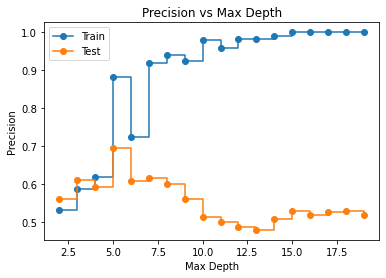

In [14]:
metrics_df      = pd.DataFrame(columns=['max_depth', 'train_precision', 'test_precision', 'test_recall', 'test_f1'])
best_model_iter = None

for max_depth_iter in range(2, model.get_depth()):
    model_iter = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth_iter, random_state=RANDOM_SEED)

    # Fit all the transformations **using the training data**
    model_iter.fit(Xt_train, y_train)

    # Predict labels for training data, for comparison
    ytrain_pred  = model_iter.predict(Xt_train)

    # Predict labels for previously unseen data
    ytest_pred = model_iter.predict(Xt_test)

    # Print performance metrics
    train_precision = sklearn.metrics.precision_score(y_train, ytrain_pred)
    precision       = sklearn.metrics.precision_score(y_test, ytest_pred)
    recall          = sklearn.metrics.recall_score(y_test, ytest_pred)
    f1              = sklearn.metrics.f1_score(y_test, ytest_pred)

    LOGGER.debug(f'Max depth: {max_depth_iter:>2} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

    if best_model_iter is None or precision > metrics_df[metrics_df.test_precision == metrics_df.test_precision.max()].head(1)['test_precision'].values[0]:
        best_model_iter = model_iter

    metrics_df = metrics_df.append({
        'max_depth':        max_depth_iter,
        'train_precision':  train_precision,
        'test_precision':   precision,
        'test_recall':      recall,
        'test_f1':          f1,
        }, ignore_index=True)

max_depth, train_precision, test_precision, test_recall, test_f1 = metrics_df[metrics_df.test_precision == metrics_df.test_precision.max()].head(1).values[0]

LOGGER.info(f'Best PRECISION: max_depth={max_depth} ... Precision: {test_precision:.2%}.  Recall: {test_recall:.2%}.  F1: {test_f1:.2%}')
LOGGER.info(f'Tree has {best_model_iter.tree_.node_count} nodes, {best_model_iter.get_n_leaves()} leaves, and a max depth of {best_model_iter.get_depth()}')

fig, ax = plt.subplots()
ax.set_xlabel("Max Depth")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Max Depth")
ax.plot(metrics_df.max_depth, metrics_df.train_precision, label='Train', marker='o', drawstyle='steps-post')
ax.plot(metrics_df.max_depth, metrics_df.test_precision, label='Test', marker='o', drawstyle='steps-post')
ax.legend()


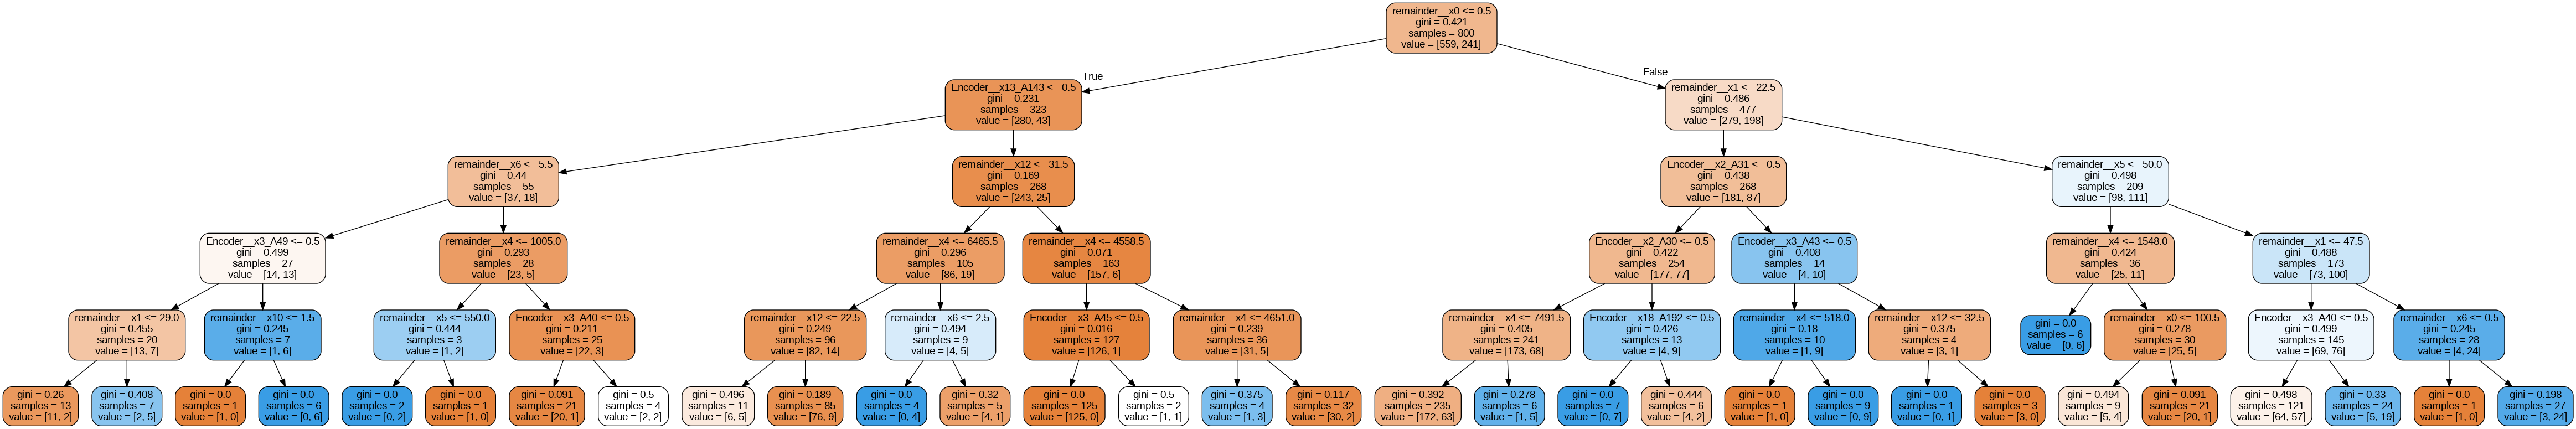

In [15]:
write_tree(best_model_iter, transformer, 'best-max-depth-tree.png')


## 3.F Conclusion

As described in the World Class forums, the column transformation did make it
more difficult to interpret the decision tree.  For example, the `A143` value
from the Other.Loans column becomes it's own column and potentially a node, as
seen above where it's entitled `Encoder_x13_A143`.

By experimenting with hyperparameters, we were able to achieve a much higher
precision of `70%`.

# 4 Random Forest Classifier

Below, we try a range of hyperparemeters and combinations to evaluate the
`RandomForestClassifier`.

**Findings:**   With `n_estimators=100.0` and a `max_depth=5.0` we are able to
                achieve a precision of `82%`.


In [16]:
MAX_N_ESTIMATORS    = 300
MAX_DEPTH           = 16
metrics_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'train_precision', 'test_precision', 'test_recall', 'test_f1'])

for n_estimator_iter in range(50, MAX_N_ESTIMATORS + 1, 50):
    LOGGER.debug(f'----- Num estimators: {n_estimator_iter:>3} -----')

    for depth_iter in range(5, MAX_DEPTH + 1):
        model_iter = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimator_iter, max_depth=depth_iter, random_state=RANDOM_SEED, n_jobs=-1)

        # Fit all the transformations **using the training data**
        model_iter.fit(Xt_train, y_train)

        # Predict labels for training data, for comparison
        ytrain_pred  = model_iter.predict(Xt_train)

        # Predict labels for previously unseen data
        ytest_pred = model_iter.predict(Xt_test)

        # Print performance metrics
        train_precision = sklearn.metrics.precision_score(y_train, ytrain_pred)
        precision       = sklearn.metrics.precision_score(y_test, ytest_pred)
        recall          = sklearn.metrics.recall_score(y_test, ytest_pred)
        f1              = sklearn.metrics.f1_score(y_test, ytest_pred)

        LOGGER.debug(f'     Max depth: {depth_iter} ... Precision: {precision:.2%}.  Recall: {recall:.2%}.  F1 Score: {f1:.2%}')

        metrics_df = metrics_df.append({
            'n_estimators':     n_estimator_iter,
            'max_depth':        depth_iter,
            'train_precision':  train_precision,
            'test_precision':   precision,
            'test_recall':      recall,
            'test_f1':          f1,
            }, ignore_index=True)


n_estimators, max_depth, train_precision, test_precision, test_recall, test_f1 = metrics_df[metrics_df.test_precision == metrics_df.test_precision.max()].head(1).values[0]

LOGGER.info(f'Best PRECISION: n_estimators={n_estimators} / max_depth={max_depth} ... Precision: {test_precision:.2%}.  Recall: {test_recall:.2%}.  F1: {test_f1:.2%}')


2022-02-06 22:45:38 - DEBUG  -   MSDS-680 - ----- Num estimators:  50 -----
2022-02-06 22:45:39 - DEBUG  -   MSDS-680 -      Max depth: 5 ... Precision: 75.00%.  Recall: 10.17%.  F1 Score: 17.91%
2022-02-06 22:45:39 - DEBUG  -   MSDS-680 -      Max depth: 6 ... Precision: 55.56%.  Recall: 16.95%.  F1 Score: 25.97%
2022-02-06 22:45:39 - DEBUG  -   MSDS-680 -      Max depth: 7 ... Precision: 69.23%.  Recall: 30.51%.  F1 Score: 42.35%
2022-02-06 22:45:40 - DEBUG  -   MSDS-680 -      Max depth: 8 ... Precision: 76.00%.  Recall: 32.20%.  F1 Score: 45.24%
2022-02-06 22:45:40 - DEBUG  -   MSDS-680 -      Max depth: 9 ... Precision: 60.87%.  Recall: 23.73%.  F1 Score: 34.15%
2022-02-06 22:45:41 - DEBUG  -   MSDS-680 -      Max depth: 10 ... Precision: 76.92%.  Recall: 33.90%.  F1 Score: 47.06%
2022-02-06 22:45:41 - DEBUG  -   MSDS-680 -      Max depth: 11 ... Precision: 70.37%.  Recall: 32.20%.  F1 Score: 44.19%
2022-02-06 22:45:42 - DEBUG  -   MSDS-680 -      Max depth: 12 ... Precision: 73.5

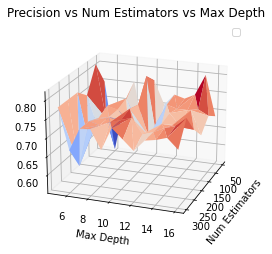

In [17]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ax.set_xlabel('Num Estimators')
ax.set_ylabel("Max Depth")
ax.set_title("Precision vs Num Estimators vs Max Depth")
ax.plot_trisurf(metrics_df.n_estimators, metrics_df.max_depth, metrics_df.test_precision,
               cmap=cm.coolwarm)
ax.view_init(20, 20)
ax.legend()


# 5 Conclusion

As expected, the `RandomForestClassifier` performs better than the previous
`DecisionTreeClassifer`s.  As an ensemble classifier, it's not as susceptible
to overfitting AND the random selection of features presents a single feature
from dominating.


# References

german_credit_risk_names.doc (n.d.)

ScikitLearn.org (n.d.).  *Post pruning decision trees with cost complexity pruning*.  Retrieved from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html